# **LinkedUp** - Your Next Co-Founder is One Swipe Away.

Finding the right co-founder or job opportunity can be time-consuming and frustrating. LinkedUp aims to use the data regrading individual to connect like-minded individuals.

Linked up uses AI techniques in order to make the right connection between two entrepreneurs. It analyzes various attributes regrading an enterpuner including: language, posistion, education, recommendations_count, volunteer_experience, сourses and relevance_score.

Using the data we extract relevant individuals - those who already founded a company. Afterwards, we define a scoring function of a company success which was founded by some entrepreneurs and then we scale it to a number between 0 and 1, we evaluate the rate of two individuals success using a neural network and the data we extracted.

We collect the content of individual posts using web-scraping and the url column, then we collect meta topics that represent our data and utilize a LLM to classify the content of the post to some topic.

Finally, we calculate a metric of education compatibility, as when matching two entrepreneurs we want them to have knowledge from two other fields, together they can integrate their both knowledge to make the perfect startup.

LinkedUp uses the following scoring matching function: 


$$
\text{Score}(u_1, u_2) = w_1 \cdot \text{successNN}(u_1, u_2)  + w_2 \cdot \text{sim}(u_{1,\text{interest}}, u_{2,\text{interest}}) + w_3 \cdot \text{comp}(u_{1,\text{education}}, u_{2,\text{education}}) $$

This function consists of weighted sum of our neural network prediction, interest similarity and education compatibility.

As higher the Score matching as higher the two candidates are mpre compatible.

After training our neural netwrok model we perform linear regression to find the optimal weights, then we evaluate our overall score function on a test data.


In [0]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import pandas as pd
import sparknlp
import seaborn as sns
from sparknlp import DocumentAssembler
spark = sparknlp.start()

In [0]:
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Tokenizer, Normalizer
from pyspark.ml import Pipeline

In [0]:
profiles = spark.read.parquet('/dbfs/linkedin_people_train_data')
companies = spark.read.parquet('/dbfs/linkedin_train_data')

We are interested to offer our tool only to our _active users_, an _active user_ is a user that has posted **at least** once and has some sort of **education**.

In [0]:
active_users = profiles.filter((size(col('posts'))>0)&(size(col('education'))>0))

## **Explanatory Data Analysis**

At LinkedUp Labs, our goal is to provide you with the **best possible matches** for a unique, personalized experience. We are committed to ensuring that your ideas come to life by connecting you with the right opportunities and people.

To achieve this, we begin by examining our data thoroughly, allowing us to match you based on your interests and aspirations, we just want to gain an insight on what we should focus on while we match you with your next co-founder.

**Job Industries**

In [0]:
unique_industries = active_users.select('current_company.industry').dropna().distinct()
industry_counts = active_users.select('current_company.industry', 'id').dropna(
    subset=['industry'], 
    how='any'
).groupBy('industry').count().withColumn(
    'percentage', 
    100 * col('count') / active_users.count()
).orderBy(col('percentage').desc())

display(industry_counts.limit(20))

industry,count,percentage
Self-employed,295,1.2118971325281407
Freelance,104,0.4272450907895818
Amazon,53,0.21773067126776766
Self-Employed,50,0.2054062936488374
Microsoft,49,0.20129816777586065
Self Employed,46,0.18897379015693042
Google,38,0.1561087831731164
Retired,38,0.1561087831731164
eXp Realty,38,0.1561087831731164
Amazon Web Services (AWS),30,0.12324377618930243


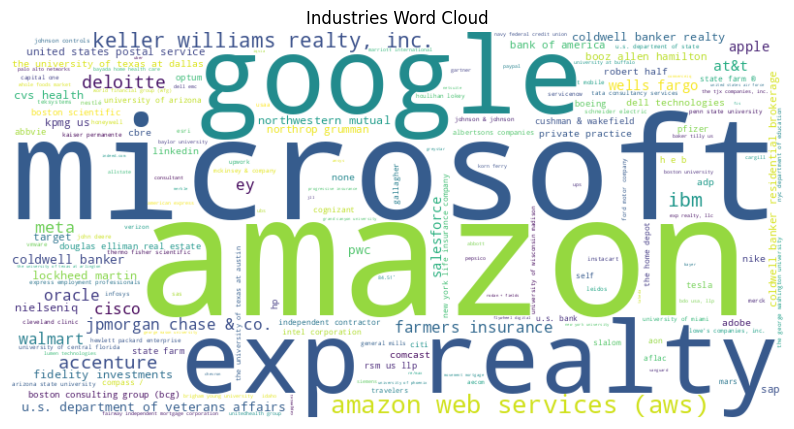

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

industry_counts_pd = industry_counts.toPandas()

industry_counts_pd['industry'] = (
    industry_counts_pd['industry']
    .str.lower()
    .str.replace('-', ' ')
    .str.strip()
)

industry_counts_pd['industry'] = industry_counts_pd['industry'].replace({
    'self employed': 'self-employed'
})

industry_counts_dict = dict(zip(industry_counts_pd['industry'], industry_counts_pd['percentage']))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(industry_counts_dict)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Industries Word Cloud')
plt.show()


**Fields of Education**

In [0]:
fields = active_users.select('id', 'education')\
    .withColumn('education_exploded', explode(col('education')))\
    .select('id', col('education_exploded.field').alias('field'))\
    .dropna(subset=['field'], how='any')\
    .groupBy('field')\
    .count()\
    .withColumn('percentage', 100 * col('count') / active_users.count())\
    .orderBy(col('count').desc())

display(fields.limit(10))

field,count,percentage
"Business Administration and Management, General",960,3.943800838057678
Marketing,761,3.126283789335305
Psychology,621,2.5511461671185605
Computer Science,615,2.5264974118807
Accounting,438,1.7993591323638156
Law,432,1.7747103771259551
Economics,426,1.7500616218880947
Business Administration,392,1.6103853422068852
Business,368,1.5117903212554433
Mechanical Engineering,336,1.3803302933201873


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

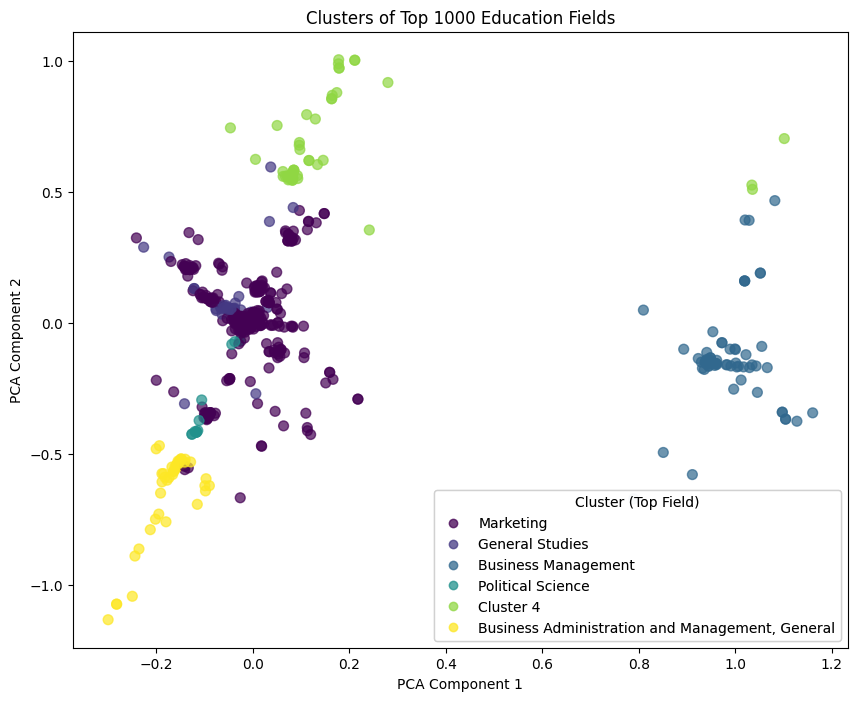

Top words per cluster (by centroid weight):

Cluster 0 (Marketing):
  Top words: ['studies', 'education', 'science', 'marketing', 'design', 'health', 'technology', 'psychology', 'sciences', 'information']

Cluster 1 (General Studies):
  Top words: ['general', 'sciences,', 'studies,', 'sales,', 'education', 'marketing', 'operations,', 'studies', 'foreign', 'development']

Cluster 2 (Business Management):
  Top words: ['management', 'information', 'services', 'marketing', 'operations', 'systems', 'finance', 'human', 'business', 'health']

Cluster 3 (Political Science):
  Top words: ['political', 'science', 'history', 'science,', 'economics', 'philosophy', 'international', '&', 'journalism,', 'relations']

Cluster 4 (Unknown):
  Top words: ['analysis', 'cultural', 'theory', '3.9', 'bioengineering', 'investments', 'sales,', 'animal', 'marketing/marketing', 'laboratory']

Cluster 5 (Business Administration and Management, General):
  Top words: ['business', 'marketing', 'administration', 'i

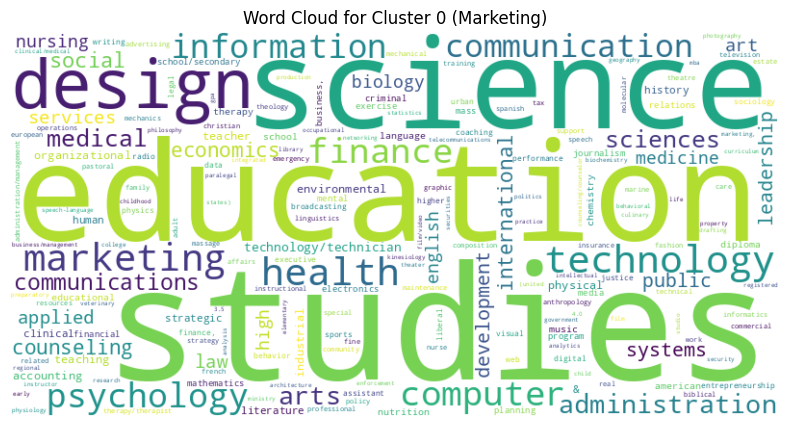

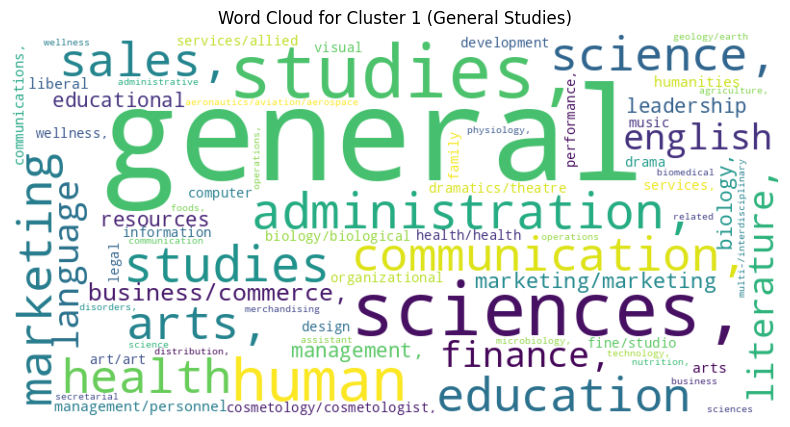

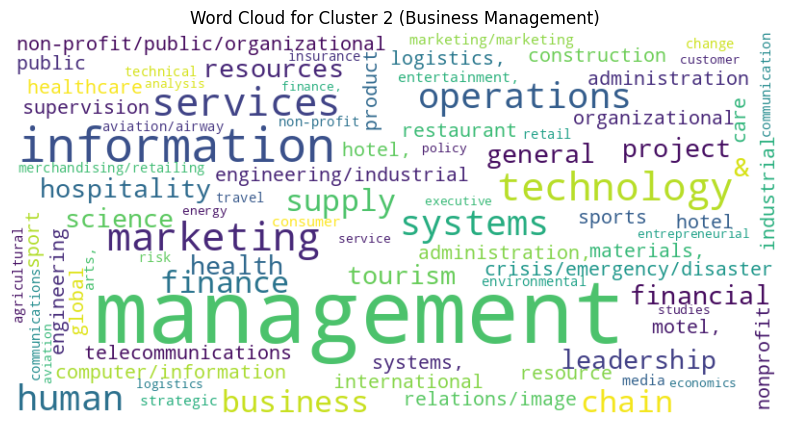

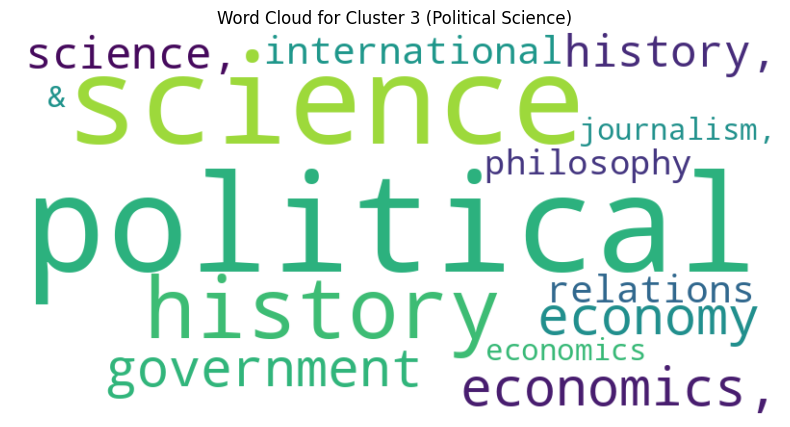

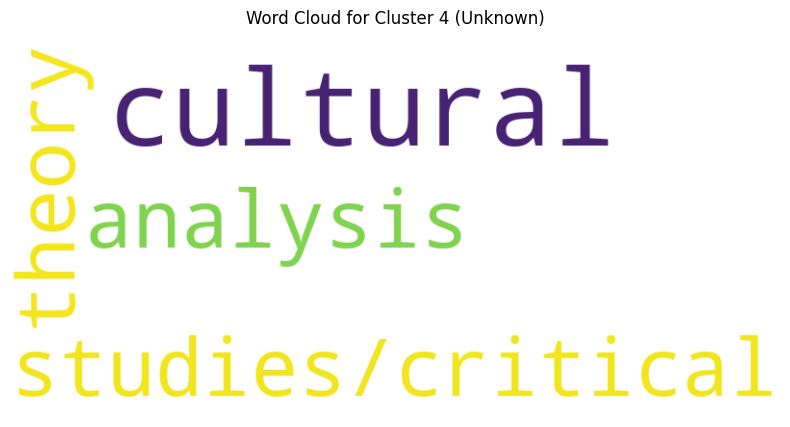

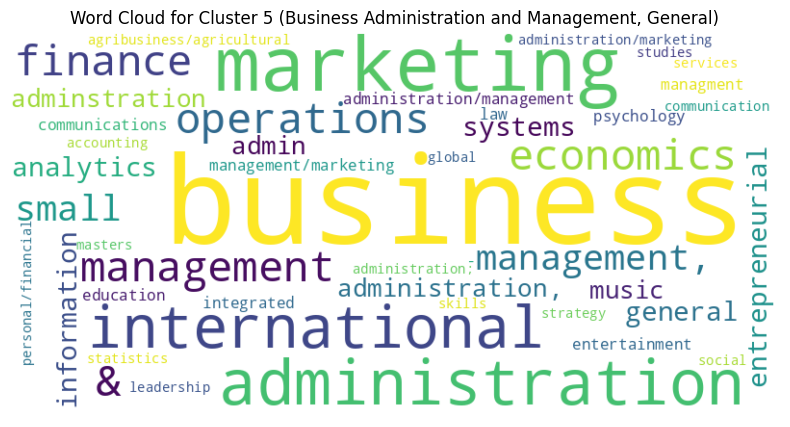

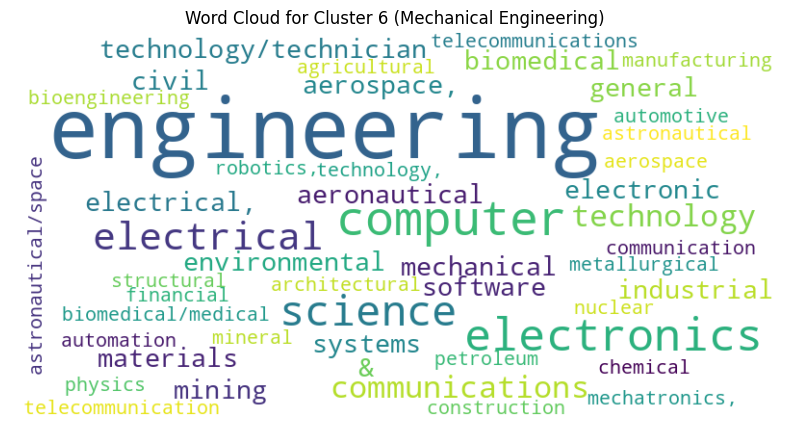

In [0]:
from pyspark.sql.functions import col, explode, count
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, PCA
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

fields_1000 = fields.limit(1000)
tokenizer = Tokenizer(inputCol="field", outputCol="words")
fields_tokenized = tokenizer.transform(fields_1000)

remover = StopWordsRemover(inputCol="words", outputCol="filtered")
fields_filtered = remover.transform(fields_tokenized)

cv = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=1000)
cv_model = cv.fit(fields_filtered)
fields_vectorized = cv_model.transform(fields_filtered)

k = 7
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=k, seed=42)
kmeans_model = kmeans.fit(fields_vectorized)
fields_clustered = kmeans_model.transform(fields_vectorized)

pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(fields_clustered)
fields_pca = pca_model.transform(fields_clustered)

# Find the most common field in each cluster
top_fields = (fields_clustered
              .groupby("cluster", "field")
              .agg(count("field").alias("count"))
              .orderBy("cluster", col("count").desc()))

top_fields_per_cluster = (top_fields.groupby("cluster").agg({"field": "first"})
                          .rdd.collectAsMap())

pandas_df = fields_pca.select("field", "count", "cluster", "pcaFeatures").toPandas()
pandas_df["pca1"] = pandas_df["pcaFeatures"].apply(lambda vec: vec[0])
pandas_df["pca2"] = pandas_df["pcaFeatures"].apply(lambda vec: vec[1])

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pandas_df["pca1"], pandas_df["pca2"],
                      c=pandas_df["cluster"], cmap='viridis', s=50, alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clusters of Top 1000 Education Fields")

# Update legend labels to show top field names
legend_labels = [top_fields_per_cluster.get(i, f"Cluster {i}") for i in range(k)]
legend1 = plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Cluster (Top Field)")
plt.gca().add_artist(legend1)
plt.show()

vocab = cv_model.vocabulary
cluster_centers = kmeans_model.clusterCenters()

print("Top words per cluster (by centroid weight):")
for i, center in enumerate(cluster_centers):
    top_indices = np.argsort(center)[-10:][::-1] 
    top_words = [vocab[idx] for idx in top_indices]
    print(f"\nCluster {i} ({top_fields_per_cluster.get(i, 'Unknown')}):")
    print("  Top words:", top_words)

print("\nSample education fields per cluster:")
for cluster_num in range(k):
    print(f"\nCluster {cluster_num} ({top_fields_per_cluster.get(cluster_num, 'Unknown')}) samples:")
    sample_fields = fields_clustered.filter(col("cluster") == cluster_num).select("field", "count").limit(10)
    sample_fields.show(truncate=False)

# Generate word clouds for each cluster
for cluster_num in range(k):
    cluster_data = fields_clustered.filter(col("cluster") == cluster_num).select("filtered")
    tokens_lists = cluster_data.rdd.flatMap(lambda row: row.filtered).collect()
    freq = {}
    for token in tokens_lists:
        freq[token] = freq.get(token, 0) + 1
    
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(freq)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Cluster {cluster_num} ({top_fields_per_cluster.get(cluster_num, 'Unknown')})")
    plt.show()

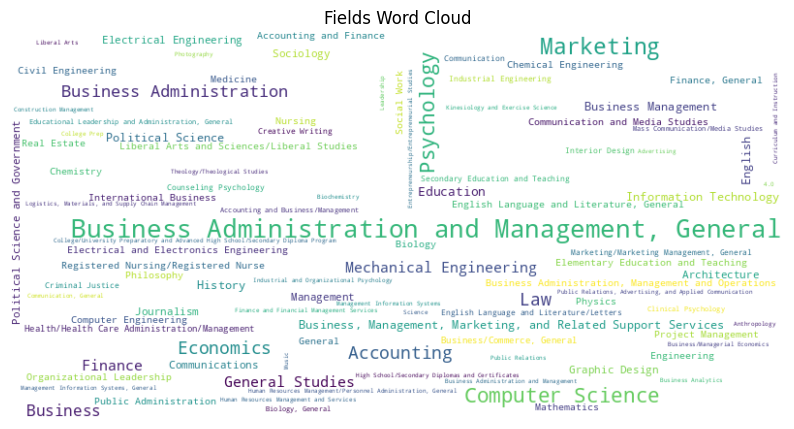

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

fields_counts_pd = fields.limit(100).toPandas()
fields_counts_dict = dict(zip(fields_counts_pd['field'], fields_counts_pd['count']))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fields_counts_dict)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Fields Word Cloud')
plt.show()

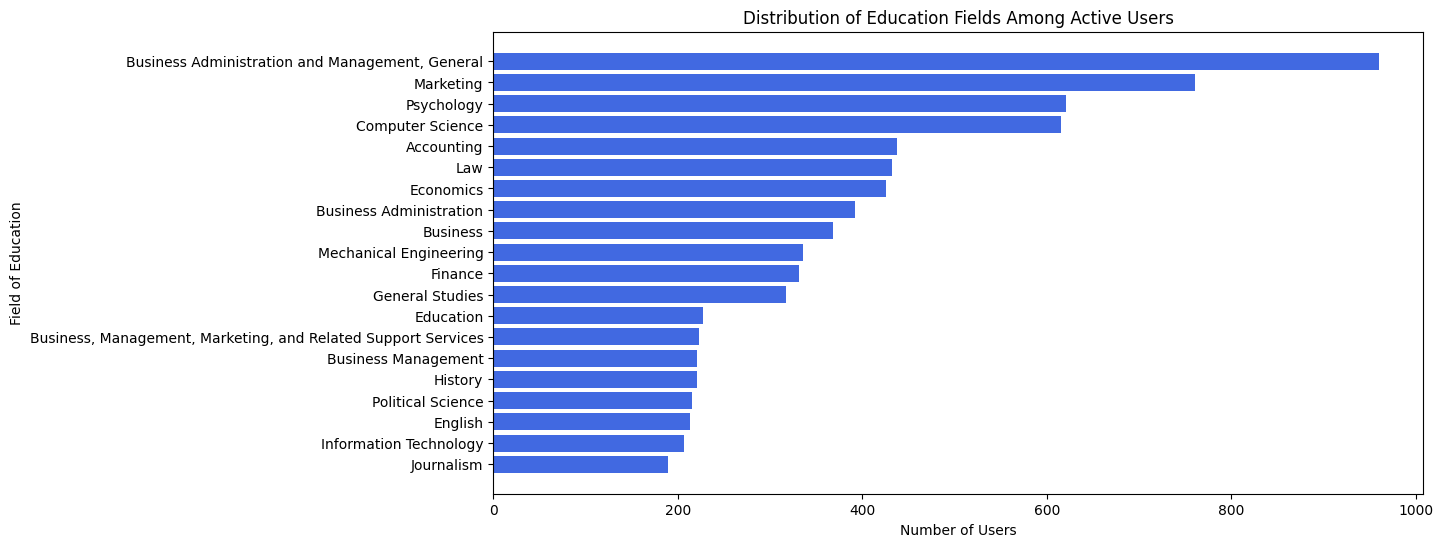

In [0]:
import matplotlib.pyplot as plt

fields_pd = fields.limit(20).toPandas()

plt.figure(figsize=(12, 6))
plt.barh(fields_pd['field'], fields_pd['count'], color='royalblue')

plt.xlabel("Number of Users")
plt.ylabel("Field of Education")
plt.title("Distribution of Education Fields Among Active Users")
plt.gca().invert_yaxis()

plt.show()

**Volunteering Causes**

In [0]:
volunteer_causes = active_users.select(
    col('id'),
    explode(col('volunteer_experience')).alias('volunteer')
).select(
    col('id'), col('volunteer.cause').alias('cause')
).dropna(subset=['cause'])

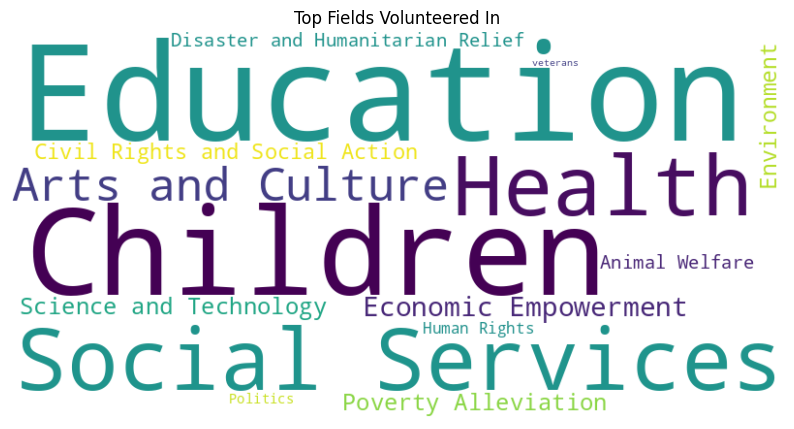

In [0]:
common_causes = volunteer_causes.groupBy("cause").count().orderBy(col("count").desc())

common_causes_pd = common_causes.limit(50).toPandas()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(
    dict(zip(common_causes_pd['cause'], common_causes_pd['count']))
)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Fields Volunteered In')
plt.show()

In [0]:
pip install fuzzywuzzy

  Obtaining dependency information for fuzzywuzzy from https://files.pythonhosted.org/packages/43/ff/74f23998ad2f93b945c0309f825be92e04e0348e062026998b5eefef4c33/fuzzywuzzy-0.18.0-py2.py3-none-any.whl.metadata
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import pandas as pd
import re
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

fields_pd = fields.select("field", "count").toPandas()

df = fields_pd.dropna().reset_index(drop=True)
df.head()

def normalize_text(text):
    if text is not None:
        return re.sub(r'[^a-zA-Z\s]', '', text.lower()).strip() if isinstance(text, str) else ''
    return ''

df['normalized'] = df['field'].apply(normalize_text)


def fuzzy_match(field, existing_fields, threshold=90):
    for existing in existing_fields:
        if fuzz.ratio(field, existing) > threshold:
            return existing  # Match found
    return field  # No close match, keep as is

unique_fields = []
df['fuzzy_matched'] = df['normalized'].apply(lambda x: fuzzy_match(x, unique_fields) or unique_fields.append(x))

df['fuzzy_matched'] = df['fuzzy_matched'].fillna('')

vectorizer = TfidfVectorizer(max_df=0.85)
X = vectorizer.fit_transform(df['fuzzy_matched'])

num_clusters = 15  
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X)


df = df.merge(fields_pd[['field', 'count']], on='field', how='left')

df.rename(columns={'count_x': 'count'}, inplace=True)

print(df[['field', 'fuzzy_matched', 'cluster', 'count']][:10])

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fc8c8b02020>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'
Ex

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

                                             field  ... count
0  Business Administration and Management, General  ...   960
1                                        Marketing  ...   761
2                                       Psychology  ...   621
3                                 Computer Science  ...   615
4                                       Accounting  ...   438
5                                              Law  ...   432
6                                        Economics  ...   426
7                          Business Administration  ...   392
8                                         Business  ...   368
9                           Mechanical Engineering  ...   336

[10 rows x 4 columns]


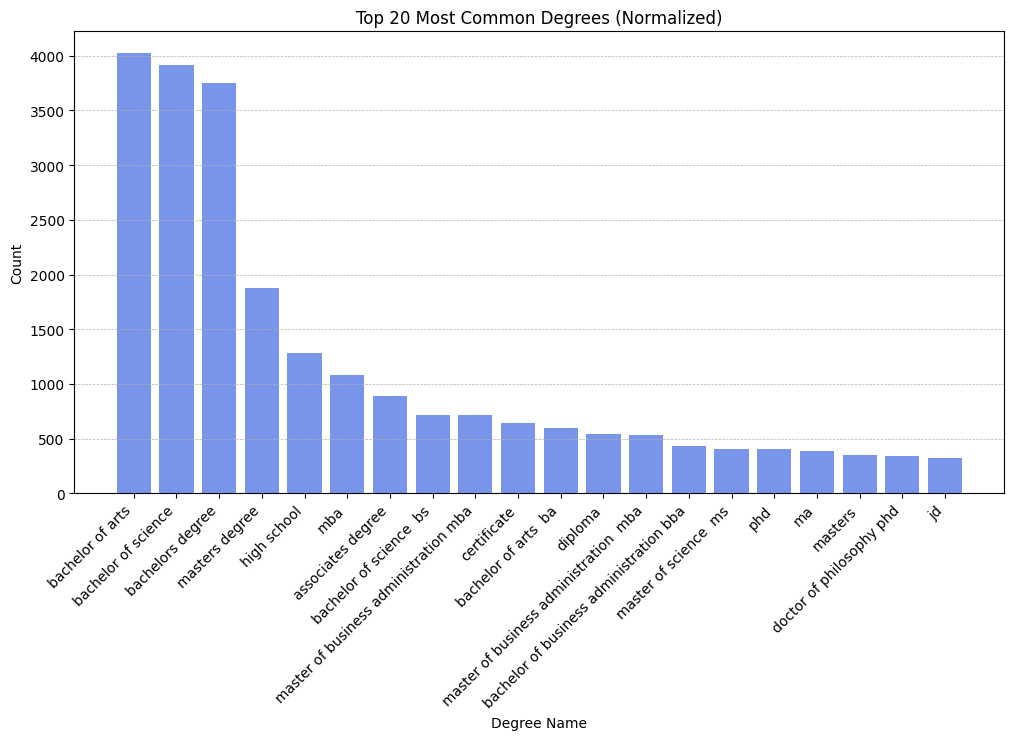

In [0]:
df_exploded = active_users.select(explode(col("education")).alias("education"))

df_degrees = df_exploded.select(col("education.degree").alias("degree")).filter(col("degree").isNotNull())

df_degrees = df_degrees.withColumn("degree", lower(trim(col("degree"))))
df_degrees = df_degrees.withColumn("degree", regexp_replace(col("degree"), "[^a-zA-Z0-9 ]", ""))

degree_mapping = {
    "bachelor of arts": ["ba", "bachelor of arts ba", "bachelor of arts"],
    "bachelor of science": ["bs", "bachelor of science bs", "bachelor of science"],
    "mba": ["master of business administration", "mba"],
    "masters degree": ["masters degree", "m.sc", "ms"],
    "bachelors degree": ["bachelors degree", "bachelors"],
    "high school": ["high school diploma", "high school"]

}

# Create a mapping function
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def normalize_degree(degree):
    degree = degree.lower().strip()
    for key, values in degree_mapping.items():
        if degree in values:
            return key
    return degree  
normalize_udf = udf(normalize_degree, StringType())
df_degrees = df_degrees.withColumn("degree", normalize_udf(col("degree")))

degree_counts = df_degrees.groupBy("degree").count().orderBy(col("count").desc()).limit(20)

degree_counts_pd = degree_counts.toPandas()

# Plot histogram
plt.figure(figsize=(12, 6))
plt.bar(degree_counts_pd['degree'], degree_counts_pd['count'], color='royalblue', alpha=0.7)

plt.xlabel("Degree Name")
plt.ylabel("Count")
plt.title("Top 20 Most Common Degrees (Normalized)")
plt.xticks(rotation=45, ha='right')  
plt.grid(axis="y", linestyle="--", linewidth=0.5)

plt.show()


In [0]:
print(cluster_labels)

cluster
0                                    journalism
1                 business management economics
2                                     education
3                              computer science
4                  computer information systems
5                                              
6             business administration marketing
7                learning design and technology
8                     television radio and film
9                          financial management
10    electronics and communication engineering
11                                       health
12          industrialorganizational psychology
13                                 business law
14               bachelor of science in nursing
Name: fuzzy_matched, dtype: object


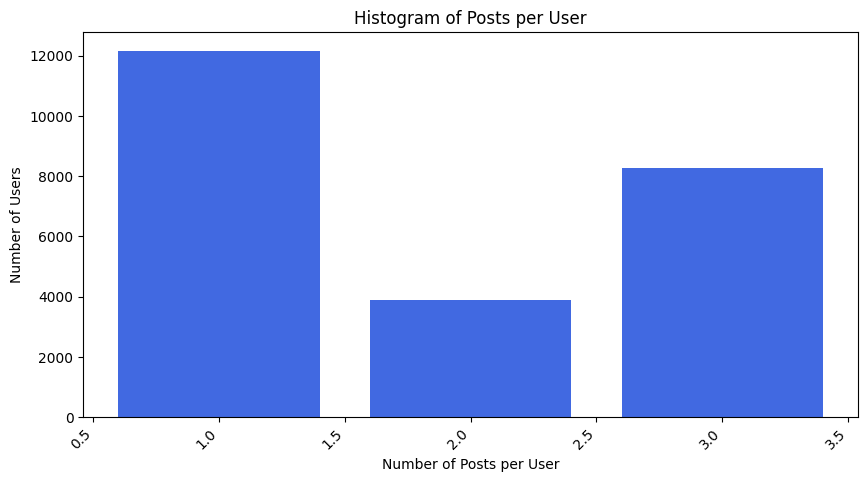

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, size
import matplotlib.pyplot as plt


user_post_counts = active_users.select("id", size(col("posts")).alias("num_posts"))

post_distribution = user_post_counts.groupBy("num_posts").count()

data = post_distribution.orderBy(col("num_posts")).collect()

num_posts = [row['num_posts'] for row in data]
num_users = [row['count'] for row in data]      
plt.figure(figsize=(10, 5))
plt.bar(num_posts, num_users, color='royalblue')

plt.xlabel("Number of Posts per User")
plt.ylabel("Number of Users")
plt.title("Histogram of Posts per User")
plt.xticks(rotation=45, ha='right')
plt.show()


## **Extracting the features**

**We offer our tool only to active users: users who have posted at least once and have some sort of education**

In [0]:
post_link = active_users.select('id','posts').withColumn('posts_exploded', explode(col('posts'))).select('id', 'posts_exploded.link')

**Web-Scraping the posts**

In [0]:
import requests
from bs4 import BeautifulSoup
def get_new_column(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        author_name_tag = soup.find('h3', class_='base-main-card__title')
        author_name = author_name_tag.text.strip() if author_name_tag else "Unknown Author"
        content_div = soup.find('div', class_='article-main__content')
        post_content = ""
        if content_div:
            paragraphs = content_div.find_all('p')#extracting all the texts in paragraphs
            post_content = "\n".join(p.text.strip() for p in paragraphs)

        return post_content
    else:
        return None
    
def prepeare_data(df):
    df_with_nulls = df.withColumn(
    "content",
    when(trim(regexp_replace(col("content"), r"[\s\n\t]+", "")) == "", None).otherwise(col("content"))
)
    return df_with_nulls

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
data_new = post_link.withColumn("content", udf(get_new_column, StringType())(post_link["link"]))
data_new = prepeare_data(data_new).select('id', 'content')
print(data_new.count())
data_new.write.mode("overwrite").parquet("/Workspace/Users/anis.barhoum@campus.technion.ac.il/data_new.csv")

44797


In [0]:
display(data_new.select('id', 'content').dropna(subset=['content']).limit(10))

id content ry-penniman-b2a9a3105 When I was a child I lived in a small town in rural Oregon. The 4th of July for me was about parades, fireworks, barbecues and red white and blue Americana. My parents taught me about diversity and inclusion but my sense of patriotism at the time was still mostly influenced by my community at large. I bought into the idea that America was #1 (at what I'm sure I didn't know) and I felt proud to be an American. Looking back, it felt good to belong to something. I wasn't a particularly "normal" kid. We didn't have a TV set in our house until the age of 12 when my grandma passed away and we inherited hers. At lunchtime, other kids would have bologna sandwiches and Lunchables, I'd have an avocado & cheese sandwich and some fruit...you get the idea. Looking back, I consider myself lucky, but at the time I was painfully aware that I was different. This likely contributed to my strong desire to belong to something. Perhaps this was the reason I so readily bought into the ideas we're indoctrinated with at a young age of American patriotism without asking why America is great. As I've gotten older I've started to question my assumptions. America, while founded on many noble principles, has a painful history, built on indigenous land by the labor of slaves and steeped in inequity for those considered different than the dominant patriarchy. I still consider myself a patriot, and I love my country. Not in any nationalist or us vs. them kind of way but in the pride I feel in living in a country where people from all over the world come together for a better life...to live freely, to love freely and to share our histories with each other.
America is great. I believe that. But to me it's not great because of the red white and blue. It's great because of the black, white and brown and all the people that call America home. America is great because of our differences, that when brought together make a beautiful mosaic. America is great because we can acknowledge our errors, our painful histories and engage in public discourse about how to be better. America is great because we know we can be better...a more perfect union. No winning team rests on its laurels after a championship and repeats "we're #1!" season after season. It takes work, determination and grit to earn greatness.
This Independence Day, I'm proud to be an American. I'll take part in the festivities, barbecue and enjoy the fireworks (if I can coax my dog out of hiding). I'll acknowledge our imperfect past and be optimistic for a better future, while reflecting on the words of Emma Lazarus:
Not like the brazen giant of Greek fame,
With conquering limbs astride from land to land;
Here at our sea-washed, sunset gates shall stand
A mighty woman with a torch, whose flame
Is the imprisoned lightning, and her name
Mother of Exiles. From her beacon-hand
Glows world-wide welcome; her mild eyes command
The air-bridged harbor that twin cities frame.
“Keep, ancient lands, your storied pomp!” cries she
With silent lips. “Give me your tired, your poor,
Your huddled masses yearning to breathe free,
The wretched refuse of your teeming shore.
Send these, the homeless, tempest-tost to me,
I lift my lamp beside the golden door!” nicwaldenmayer Many manufacturing companies fail to take advantage of the generous research and development (R&D) tax credit simply because they don’t have staff working in a lab. The Internal Revenue Service’s (IRS) definition of R&D may not be exactly what you think it is.
From 2018 to 2027, the estimated value of R&D tax credits to be claimed by U.S. companies is estimated at $163 billion, with $148 billion of that going to corporations.
You can take advantage of this tax credit as long as your company performs activities such as the following:
This list is not all-inclusive. According to the IRS, many activities may qualify if they are performed in the United States and meet the following four-part test.
Part 1. Permitted purpose
The IRS 

**Labeling the posts to better understand your passions**

In [0]:
%pip install transformers accelerate sentencepiece bitsandbytes pyspark


com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:138)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:728)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:446)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:446)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:464)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:571)
	at com.data

In [0]:
%pip install transformers torch huggingface_hub


com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:138)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:728)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:446)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:446)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:464)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:571)
	at com.data

In [0]:
from pyspark.sql.types import BooleanType

active_users_exploded = active_users.withColumn("experience", explode(col("experience")))
keywords = ['founder', 'co-founder', 'owner', 'co founder', 'partner']

def contains_keyword(position):
    if position is None:
        return False
    position_lower = position.lower()
    return any(keyword in position_lower for keyword in keywords)

contains_keyword_udf = udf(contains_keyword, BooleanType())

filtered_df = active_users_exploded.filter(contains_keyword_udf("position"))

In [0]:
from datetime import datetime, timezone

def calculate_time_ago(time_element):
    datetime_value = time_element.get("datetime")
    if datetime_value:
        post_time = datetime.fromisoformat(datetime_value.replace("Z", "+00:00"))
        now = datetime.now(timezone.utc)
        time_diff = now - post_time
    return time_diff.total_seconds()

In [0]:
data_new1 =  spark.read.parquet("/Workspace/Users/anis.barhoum@campus.technion.ac.il/data_new.csv")
display(data_new1.drop('id_a').limit(10))

id content katerinakrstic After a long week of misunderstandings, the decision was finally made. Maya (not her real name, as Maya wishes to remain private) was somewhat relieved that the following day, she would be admitted to a hospital and receive the much-needed care for her condition. For the past year, Maya had gone through a series of partial treatments, and each seemed to make things worse.
It will take another two excruciating weeks for Maya to know if she will have access to a full treatment or another partial treatment. Maya’s only hope for recovery is access to a full treatment. Her anxiety, fueled by uncertainty over those two weeks, makes this round of initial assistance that much harder. Maya needs to believe that she is worthy of a chance and access to full care. It feels as if this time, Maya is hanging on by a thread. She is tired.
This is not the first time Maya has headed to the hospital. It’s a journey she’s been following for the last ten years. She managed well before the pandemic, juggling her university classes and barista job, but the additional stress of the pandemic presented new challenges. A recent article in the New York Times reported on the recommendation by a panel of medical experts that all adult patients younger than 65 should be screened for anxiety suggesting Maya has plenty of company.  Maya is quiet, sensitive, and deeply caring about others. Maya is one of my dearest friends and Maya has an eating disorder.
30 million Americans who are alive today will have an eating disorder in their lifetime. One person dies every 52 minutes as direct result of an eating disorder. The National Eating Disorders Association (NEDA) supports individuals and families affected by eating disorders. They’ve made a huge difference in helping me support my friend and I ask you to support them by donating through my NEDA fundraiser page. seanhalter 2021’s biggest marketing challenge is generating traffic and leads, according to a report by HubSpot, Litmus, and Wistia surveyed over 1,500 marketers across the world.
It’s no debate that we live in an oversaturated world, filled to the brim with digital content. We scroll, and scroll, and scroll - but what makes us click? In this age, it’s no wonder that the challenge of generating traffic is on people’s minds.
So, how can a business create more leads, turn those leads into customers, and convert those customers into repeat buyers and passionate ambassadors of our brand?
It starts with the content we produce and why we produce it. Spending time, energy, and money creating content without considering the “why” behind it will only leave you disappointed.
Now, the pressure to make unique and impactful content is higher than ever. Let’s look to some industry players who are making waves with their creative lead generation techniques.
Skincare brand Curology uses personalized quizzes to drive traffic and leads. Their focus on delivering customized solutions puts their customers at the center of their content strategy. Who doesn’t want to know the secret formula to perfect their individual skincare issues? In order to access the quiz results, users must enter their email address. This is another layer of lead generation - gather interested customers’ contact information for future engagements.
TravelUp and LATAM Airlines teamed up to host a contest to promote flights to Brazil, gather user-generated content, and compile contact data. The contest encouraged social media users to create and share their own designs using an app called Scenes. The prize? Flight tickets to Sao Paulo. Hundreds of submissions piled in. This means hundreds of email addresses, website clicks, and people who engaged with both companies. Converting these giveaway participants into customers just became easier.
Devonshire Hotels & Restaurants designed a matching game for Valentine’s Day. The matching game required players to connect two photo pairs as quickly as possible. The prize was a chance to wi

In [0]:
pip install gensim

  Obtaining dependency information for gensim from https://files.pythonhosted.org/packages/78/4f/f6045d5d5f8e7838c42572607ce440f95dbf4de5da41ae664198c2839c05/gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/26.7 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.2/26.7 MB 5.7 MB/s eta 0:00:05
   ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.6/26.7 MB 8.6 MB/s eta 0:00:04
   ━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/26.7 MB 10.8 MB/s eta 0:00:03
   ━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/26.7 MB 13.0 MB/s eta 0:00:02
   ━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/26.7 MB 15.4 MB/s eta 0:00:02
   ━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/26.7 MB 18.5 MB/s eta 0:00:02
   ━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/26.7 MB 22.0 MB/s eta 0:00:01
   ━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/26.7 MB 26.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/26.7 MB 31.8 MB/s eta

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import pandas_udf, col
from pyspark.sql.types import StringType
import pandas as pd
from sentence_transformers import SentenceTransformer
import numpy as np
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, strip_numeric, strip_short, remove_stopwords


data_new = data_new1.limit(100000).repartition(8)


# Define startup topics
startup_topics = [
    "Machine Learning and AI",
    "Cosmetics",
    "Law",
    "Marketing",
    "Software Engineering",
    "Healthcare",
    "Project Management",
    "UX/UI Design",
    "Cybersecurity",
    "Finance",
    "Human Resources",
    "Public Relations",
    "Architecture",
    "Culinary",
    "Environment",
    "Sales",
    "Event Planning",
    "Construction",
    "Logistics",
    "Veterinarian",
    "Fashion",
    "Real Estate",
    "Education",
    "Psychology",
    "Travel"
]


def preprocess_post(posts: pd.Series) -> pd.Series:
    CUSTOM_FILTERS = [
        lambda x: x.lower(),
        strip_punctuation,
        strip_numeric,
        strip_short,
        remove_stopwords
    ]
    return posts.fillna("").apply(lambda post: preprocess_string(post, CUSTOM_FILTERS))

@pandas_udf(StringType())
def preprocess_udf(posts: pd.Series) -> pd.Series:
    return preprocess_post(posts).apply(lambda tokens: " ".join(tokens))  # Convert list to string

new_data = data_new.withColumn("processed_content", preprocess_udf(col("content")))

model = SentenceTransformer('all-MiniLM-L6-v2', cache_folder="/dbfs/tmp/sentence_transformers/")

# Compute topic embeddings once
topic_embeddings = model.encode(startup_topics, normalize_embeddings=True)

def match_topic(posts: pd.Series) -> pd.Series:
    post_embeddings = model.encode(posts, normalize_embeddings=True)  
    similarities = np.dot(post_embeddings, topic_embeddings.T)       
    best_match_indices = similarities.argmax(axis=1)                 
    return pd.Series([startup_topics[i] for i in best_match_indices]) # Return matched topic

@pandas_udf(StringType())
def match_topic_udf(posts: pd.Series) -> pd.Series:
    return match_topic(posts)


final_df = new_data.withColumn("matched_topic", match_topic_udf(col("processed_content")))

#display(final_df.select("id", "matched_topic", "content").limit(10))
final_df.write.mode("overwrite").parquet("/Workspace/Users/anis.barhoum@campus.technion.ac.il/final_df1.csv")


/databricks/python/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [0]:
from pyspark.sql.functions import col, pandas_udf
from pyspark.sql.types import FloatType
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


model = SentenceTransformer("all-MiniLM-L6-v2")

unique_fields = fields.select("field").distinct().limit(1000).toPandas()

embedding_dict = {field: model.encode(field) for field in unique_fields["field"]}

unique_fields_df = spark.createDataFrame(pd.DataFrame(unique_fields, columns=["field"]))

pairs_df = unique_fields_df.alias("a").crossJoin(unique_fields_df.alias("b"))\
    .filter(col("a.field") < col("b.field"))  


@pandas_udf(FloatType())
def batch_education_similarity(field1_series: pd.Series, field2_series: pd.Series) -> pd.Series:
    scores = []
    for field1, field2 in zip(field1_series, field2_series):
        vec1 = embedding_dict.get(field1, None)
        vec2 = embedding_dict.get(field2, None)
        if vec1 is None or vec2 is None:
            scores.append(0.0)  
        else:
            score = cosine_similarity([vec1], [vec2])[0][0]
            scores.append(float(score))
    return pd.Series(scores)

pairs_with_scores = pairs_df.withColumn(
    "similarity_score",
    batch_education_similarity(col("a.field"), col("b.field"))
)

final_df = pairs_with_scores.select(
    col("a.field").alias("Field1"),
    col("b.field").alias("Field2"),
    col("similarity_score").alias("Similarity Score")
)

final_df.orderBy("Similarity Score", ascending=False).show(20, truncate=False)


+--------------------------+--------------------------+----------------+
|Field1                    |Field2                    |Similarity Score|
+--------------------------+--------------------------+----------------+
|Nursing                   |nursing                   |1.0000002       |
|N/A                       |n/a                       |1.0000001       |
|Chemistry                 |chemistry                 |1.0000001       |
|Business                  |business                  |1.0000001       |
|Medicine                  |medicine                  |1.0000001       |
|Information Systems       |Information systems       |1.0000001       |
|High school               |high school               |1.0             |
|High School               |high school               |1.0             |
|Law                       |law                       |1.0             |
|Economics                 |economics                 |1.0             |
|High School               |High school            

In [0]:
mode_df = (
    final_df.groupBy("id", "matched_topic")
    .count()  
    .withColumn("rank", row_number().over(Window.partitionBy("id").orderBy(desc("count")))) 
    .filter(col("rank") == 1) 
    .select("id", "matched_topic")  
)
mode_df.show()

+--------------------+---------------+
|                  id|  matched_topic|
+--------------------+---------------+
|          Curtcooper|   Construction|
|      Margarita-cruz|        Fashion|
|      aaronschnieder|    Environment|
|       adrianegarcia|  Cybersecurity|
|  ajit-singh-artiman|     Psychology|
|      alexandraosten|     Healthcare|
|     amberschuchmann|    Real Estate|
|        ambhiganesan|      Marketing|
|         aminathomas|   Veterinarian|
|amol-helekar-2270...|      Marketing|
|         anandjain02|      Logistics|
|andrew-goff-64a26a35|      Marketing|
|            andypham|Human Resources|
|          andystento|  Cybersecurity|
|angel-suarez-82828ab|      Marketing|
|angela-geels-a8b2...|      Marketing|
|       anne-susemihl|         Travel|
|     anthonymcolella|      Logistics|
|ashley-clark-2979...|      Marketing|
|    authorwhmitchell|   Architecture|
+--------------------+---------------+
only showing top 20 rows



**GOOGLE NEWS**


The proposed scoring function combines recency and popularity to rank posts. The score is calculated as:
$$
Score = \frac{P} {1 + α \cdot T}
$$
Where:
- P: Popularity (number of posts or mentions).
- T: Total time since the posts were posted (in seconds).
- α: A weighting factor that controls the impact of time decay (higher values penalize older posts more).
- 1: A smoothing factor to prevent division by zero and ensure a base score for recent posts.

If no posts exists P = 0 then the relevance score will set to 0.

The intuition is as the number of posts about a company is as the number of news headlines about the company is greater, as the relevance score will be greater.

We also put an emphasis of how relevant the comapny is, so we divide with the total time since the posts were posted (in seconds as it is the smallest unit of measure in DateTime object).


In [0]:
import requests
from bs4 import BeautifulSoup
alpha = 0.02

def get_scoring(company_name):
    url = f"https://news.google.com/search?q={company_name}"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    time = 0
    buttons = soup.find_all("button", class_="VfPpkd-Bz112c-LgbsSe yHy1rc eT1oJ mN1ivc hUJSud")
    number_of_posts = 0

    for button in buttons:
        aria_label = button.get("aria-label", "")
        time_element = button.find_next("time", class_="hvbAAd")
        if company_name.lower() in aria_label.lower():
            number_of_posts += 1
            time += calculate_time_ago(time_element)
    return number_of_posts / (1 + alpha * time)

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:138)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:728)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:446)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:446)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:464)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:571)
	at com.data

Looking at compnaies we had more than one founders as the rest aren't relvant for evaluating the model

In [0]:
distinct_name = filtered_df.dropDuplicates(["id"])
grouped_df = distinct_name.groupBy("current_company:name").count()
filtered_df_ = grouped_df.filter(col("count") > 1).dropna()
display(filtered_df_.limit(10))

current_company:name,count
Amazon Web Services (AWS),2
OneStone,2
Chicory,2
McLeod Software,2
Walmart,2
Self Employed,3
AssuredPartners,2
RSM US LLP,4
Bain & Company,2
Spartan Training & Performance,2



Removing redundant companies.

In [0]:
names = filtered_df_.join(distinct_name, on = "current_company:name", how = "inner")
blacklist = ['self-employed', 'selfemployed', 'OWNER', 'self employed', 'retired']

# Combine the blacklist into a regular expression pattern (case-insensitive)
pattern = "|".join([term.lower() for term in blacklist])

# Filter rows where 'current_company:name' contains any of the blacklist terms
names = names.filter(~lower(col('current_company:name')).rlike(pattern))

In [0]:
names.write.mode("overwrite").parquet("/Workspace/Users/anis.barhoum@campus.technion.ac.il/joined_df.csv")

After saving the frame we load it (saving computation time).

In [0]:
names = spark.read.parquet("/Workspace/Users/anis.barhoum@campus.technion.ac.il/joined_df.csv")

The following code ran in our PC to save computation time in the machine - we downloaded all the distinct relevant companies from the data bricks.

Then we imported the csv file to the data bricks.

In [0]:
import time
def extract_scores():
    companies = names.select("current_company:name").distinct().collect()
    ratings = []
    companies = []
    for i, company in enumerate(companies):
        time.sleep(2)
        rating = get_scoring(company)
        ratings.append(rating)
        companies.append(company)

        results_frame = pd.DataFrame({
            "Company Name": companies,
            "Rating": ratings
        })

    results_frame.to_csv('company_ratings.csv', index=False)


com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:138)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:728)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:446)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:446)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:464)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:571)
	at com.data

In [0]:
import pandas as pd
scores = pd.read_csv("company_ratings.csv")
scores_spark = spark.createDataFrame(scores)

In [0]:
names = names.join(scores_spark, on=scores_spark["Company Name"] == names["current_company:name"], how="inner")

Here we extacted the relveant columns: 

id, names, languages, posistion, education, recommendations_count, volunteer_experience, сourses and relevance_score.

We will use all of those to train our neural networks next.

We paired relevant profiles together to a row - those who founded together a company. 

In [0]:
from pyspark.sql.functions import collect_list, struct, col, explode

grouped_sdf = names.groupBy("current_company:name").agg(
    collect_list(struct(
        "id","name", "languages", "position", "recommendations_count", "education", 
        "volunteer_experience", "сourses", "Rating"
    )).alias("founders")
)

pairs_sdf = grouped_sdf.select(
    col("current_company:name"),
    explode(col("founders")).alias("person_a"),
    explode(col("founders")).alias("person_b")
).filter(col("person_a.name") != col("person_b.name"))

pairs_sdf = pairs_sdf.select(
    col("person_a.id").alias("id_a"),
    col("person_b.id").alias("id_b"),
    col("person_a.name").alias("name_a"),
    col("person_b.name").alias("name_b"),
    col("person_a.languages").alias("languages_a"),
    col("person_b.languages").alias("languages_b"),
    col("person_a.position").alias("position_a"),
    col("person_b.position").alias("position_b"),
    col("person_a.education").alias("education_a"),
    col("person_b.education").alias("education_b"),
    col("person_a.recommendations_count").alias("recommendations_count_a"),
    col("person_b.recommendations_count").alias("recommendations_count_b"),
    col("person_a.volunteer_experience").alias("volunteer_experience_a"),
    col("person_b.volunteer_experience").alias("volunteer_experience_b"),
    col("person_a.сourses").alias("сourses_a"),
    col("person_b.сourses").alias("сourses_b"),
    col("person_a.Rating").alias("relevance_score_a"),
    col("person_b.Rating").alias("relevance_score_b")
).dropDuplicates(['id_a', 'id_b'])

After performing all the computations above we save the spark data frame again to avoid redundant computations.

In [0]:
pairs_sdf.write.mode("overwrite").parquet("/Workspace/Users/anis.barhoum@campus.technion.ac.il/pairs_sdf.csv")

In [0]:
pairs_df = spark.read.parquet("/Workspace/Users/anis.barhoum@campus.technion.ac.il/pairs_sdf.csv")

We process candidate pairs by computing their similarity across various textual attributes, such as education, languages, volunteer experience, courses, and job positions.

First, we clean and standardize the text data, ensuring missing values are properly handled. Using TF-IDF vectorization and cosine similarity, to quantify the textual similarity between corresponding attributes of two candidates. We use it afterwards for our coming model.

In [0]:
from pyspark.sql.functions import col, udf, when, lit
from pyspark.sql.types import DoubleType, FloatType
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


def preprocess_text(doc):
    if isinstance(doc, list): 
        doc = " ".join(str(item) for item in doc if item)
    elif doc is None:  
        doc = ""
    elif isinstance(doc, str):
        doc = doc.strip()
    else:
        doc = str(doc)  
    
    return doc if doc.strip() else "empty_text"  

# UDF for cosine similarity
def cosine_similarity_udf(doc1, doc2):
    doc1 = preprocess_text(doc1)  
    doc2 = preprocess_text(doc2)

    if doc1 == "empty_text" or doc2 == "empty_text":
        return 0.0  # Return zero similarity for empty docs as we don't have any information about these

    vectorizer = TfidfVectorizer()
    
    try:
        tfidf_matrix = vectorizer.fit_transform([doc1, doc2])
        similarity = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]
    except ValueError:  
        return 0.0  # Return zero similarity if vocabulary is empty

    return float(similarity)



cosine_similarity_spark_udf = udf(cosine_similarity_udf, FloatType())

string_cols = ["position_a", "position_b"]

array_cols = ["languages_a", "languages_b", "volunteer_experience_a", 
              "volunteer_experience_b", "сourses_a", "сourses_b", "education_a", "education_b"]

compatibility_df = pairs_df.fillna({col_name: "" for col_name in string_cols})

for col_name in array_cols:
    compatibility_df = compatibility_df.withColumn(
        col_name, when(col(col_name).isNull(), lit([])).otherwise(col(col_name))
    )

compatibility_df = compatibility_df.withColumn(
    "education_similarity", cosine_similarity_spark_udf(col("education_a"), col("education_b"))
)

compatibility_df = compatibility_df.withColumn(
    "languages_similarity", cosine_similarity_spark_udf(col("languages_a"), col("languages_b"))
)

compatibility_df = compatibility_df.withColumn(
    "volunteer_similarity", cosine_similarity_spark_udf(col("volunteer_experience_a"), col("volunteer_experience_b"))
)

compatibility_df = compatibility_df.withColumn(
    "courses_similarity", cosine_similarity_spark_udf(col("сourses_a"), col("сourses_b"))
)

compatibility_df = compatibility_df.withColumn(
    "position_similarity", cosine_similarity_spark_udf(col("position_a"), col("position_b"))
)


features_sdf = compatibility_df.select(
    "id_a", "id_b",  # Keeping IDs for identification
    "languages_similarity", 
    "position_similarity", 
    "education_similarity",
    "volunteer_similarity", 
    "courses_similarity",
    "relevance_score_a",
    "education_a",
    "education_b"
)


For training our neural networks in pytorch we convert our spark data frame to pandas.

In [0]:
features = features_sdf.toPandas()

In [0]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

original_y = features["relevance_score_a"].values.reshape(-1, 1) 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_y = scaler.fit_transform(original_y).flatten()
transformed_y = scaled_y ** 2 # we want to give more weight to larger scores (0-1)

We split the data with a test size of 0.5 in order to use some of the test data to train the weights.

Recall - our score function consists of some metrics:

$$
Score matching(u_1, u_2) = W_1 \cdot modelNN(u_1, u_2)  + W_2 \cdot interest similarity(u_1, u_2) + W_3 \cdot education compatibility(u_1, u_2) $$


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, transformed_y, test_size=0.5, random_state=42)

X_train_nn = X_train.drop(columns=['id_a', 'id_b'])
X_train_nn = X_train_nn.drop(columns=['relevance_score_a', "education_a", "education_b"])

X_test_nn = X_test.drop(columns=['id_a', 'id_b'])
X_test_nn = X_test_nn.drop(columns=['relevance_score_a', "education_a", "education_b"])


# Convert to tensors
X_train_nn = torch.tensor(X_train_nn.values, dtype=torch.float32)
y_train_nn = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_nn = torch.tensor(X_test_nn.values, dtype=torch.float32)
y_test_nn = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


Here we define our neural network model (MatchNN) and save the model to use it in order to predict given two new users.

The MatchNN neural network is a fully connected feedforward model designed for binary classification, used for matching or similarity scoring. It takes an input vector of a given dimension and processes it through five dense layers with decreasing sizes (256 → 128 → 64 → 32 → 1). Each hidden layer applies batch normalization, ReLU activation, and dropout (30%) to enhance training stability and prevent overfitting. The final layer outputs a single value passed through a sigmoid activation, making it suitable for probability-based predictions (e.g., determining if two candidates are a good match).

In [0]:
import torch.nn as nn
class MatchNN(nn.Module):
    def __init__(self, input_dim):
        super(MatchNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.3)

        self.fc5 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout1(self.relu1(self.bn1(self.fc1(x))))
        x = self.dropout2(self.relu2(self.bn2(self.fc2(x))))
        x = self.dropout3(self.relu3(self.bn3(self.fc3(x))))
        x = self.dropout4(self.relu4(self.bn4(self.fc4(x))))
        x = self.sigmoid(self.fc5(x))
        return x

points = []
model = MatchNN(input_dim=X_train_nn.shape[1])
criterion = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

points = []  

train_losses = []
test_losses = []

num_epochs = 500

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train_nn)
    loss = criterion(outputs, y_train_nn)

    train_losses.append(loss.detach().cpu().item())  

    loss.backward()
    optimizer.step()

    
    model.eval()  
    with torch.no_grad():
        test_outputs = model(X_test_nn)
        test_loss = criterion(test_outputs, y_test_nn)
        test_losses.append(test_loss.detach().cpu().item()) 

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")


# Save the entire model
torch.save(model, "/Workspace/Users/anis.barhoum@campus.technion.ac.il/match_nn_full_model.pth")
print("Entire model saved as 'match_nn_full_model.pth'")


Epoch [1/500], Train Loss: 0.7055, Test Loss: 0.6748
Epoch [2/500], Train Loss: 0.7165, Test Loss: 0.6732
Epoch [3/500], Train Loss: 0.7631, Test Loss: 0.6685
Epoch [4/500], Train Loss: 0.7247, Test Loss: 0.6648
Epoch [5/500], Train Loss: 0.6932, Test Loss: 0.6612
Epoch [6/500], Train Loss: 0.6789, Test Loss: 0.6591
Epoch [7/500], Train Loss: 0.6753, Test Loss: 0.6579
Epoch [8/500], Train Loss: 0.6738, Test Loss: 0.6559
Epoch [9/500], Train Loss: 0.6727, Test Loss: 0.6551
Epoch [10/500], Train Loss: 0.6503, Test Loss: 0.6532
Epoch [11/500], Train Loss: 0.6704, Test Loss: 0.6497
Epoch [12/500], Train Loss: 0.6452, Test Loss: 0.6455
Epoch [13/500], Train Loss: 0.6400, Test Loss: 0.6440
Epoch [14/500], Train Loss: 0.6173, Test Loss: 0.6432
Epoch [15/500], Train Loss: 0.6315, Test Loss: 0.6426
Epoch [16/500], Train Loss: 0.6178, Test Loss: 0.6408
Epoch [17/500], Train Loss: 0.6125, Test Loss: 0.6396
Epoch [18/500], Train Loss: 0.6063, Test Loss: 0.6370
Epoch [19/500], Train Loss: 0.5985, T

We plot the our model graph of train and test loss as function of the epochs.

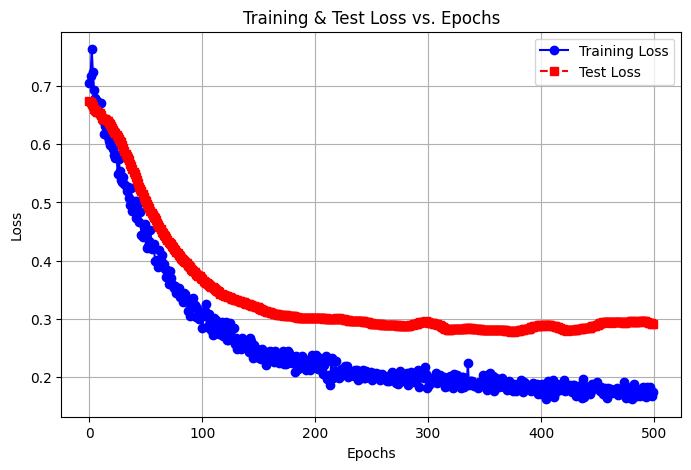

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))


plt.plot(range(num_epochs), train_losses, marker='o', linestyle='-', label="Training Loss", color='blue')

plt.plot(range(num_epochs), test_losses, marker='s', linestyle='--', label="Test Loss", color='red')


plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Test Loss vs. Epochs")
plt.legend()
plt.grid(True)
plt.show()


After checking the performance of the model we use our test data to evaluate the weight and afterwards to test our model.

This time we split the test data.

This problem is Logistic Regression problem.

In [0]:
X, X_test, y, y_test = train_test_split(X_test, y_test, test_size=0.8, random_state=42)

In [0]:
#mode_df = mode_df.toPandas()
education_comp = spark.read.parquet("/Workspace/Users/anis.barhoum@campus.technion.ac.il/education_comp.csv").toPandas()

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:445)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:464)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:571)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:528)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:633)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:656)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:48)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:276)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(Attr

Integrating the previous data frame to understand the topic of every person (the mode of the topics in a person's posts) 

In [0]:
with_tags = X.merge(mode_df, left_on='id_a', right_on='id', how='left').rename(columns={'matched_topic': 'matched_topic_1'})
with_tags_test = X_test.merge(mode_df, left_on='id_a', right_on='id', how='left').rename(columns={'matched_topic': 'matched_topic_1'})

In [0]:
with_tags = with_tags.merge(mode_df, left_on='id_b', right_on='id', how='left').rename(columns={'matched_topic': 'matched_topic_2'})
with_tags_test = with_tags_test.merge(mode_df, left_on='id_b', right_on='id', how='left').rename(columns={'matched_topic': 'matched_topic_2'})

Now we will generate all the pairs of education fields for every pair and calculate its 

In [0]:
import pandas as pd
import numpy as np
from itertools import product


with_tags['education_a'] = with_tags['education_a'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
with_tags['education_b'] = with_tags['education_b'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

def extract_fields(education_list):
    if isinstance(education_list, list):
        return [edu['field'] for edu in education_list if isinstance(edu, dict) and 'field' in edu]
    return education_list

with_tags['education_a'] = with_tags['education_a'].apply(extract_fields)
with_tags['education_b'] = with_tags['education_b'].apply(extract_fields)

def generate_pairs(row):
    if isinstance(row['education_a'], list) and isinstance(row['education_b'], list):
        return list(product(row['education_a'], row['education_b'])) if row['education_a'] and row['education_b'] else None
    return None

with_tags['education_pairs'] = with_tags.apply(generate_pairs, axis=1)
valid_rows = with_tags[with_tags['education_pairs'].notna()]
if not valid_rows.empty:
    with_tags_exploded = valid_rows.explode('education_pairs')
    with_tags_exploded[['Field1', 'Field2']] = pd.DataFrame(
        with_tags_exploded['education_pairs'].dropna().tolist(), index=with_tags_exploded.index
    )

    with_tags_exploded['Field1'] = with_tags_exploded['Field1'].astype(str)
    with_tags_exploded['Field2'] = with_tags_exploded['Field2'].astype(str)
    education_comp['Field1'] = education_comp['Field1'].astype(str)
    education_comp['Field2'] = education_comp['Field2'].astype(str)

    with_tags_exploded = with_tags_exploded.drop(columns=['education_pairs'])

    merged1 = with_tags_exploded.merge(
        education_comp, 
        left_on=['Field1', 'Field2'], 
        right_on=['Field1', 'Field2'], 
        how='left'
    )

    merged2 = with_tags_exploded.merge(
        education_comp, 
        left_on=['Field1', 'Field2'], 
        right_on=['Field2', 'Field1'], 
        how='left'
    )

    final_with_tags = merged1.combine_first(merged2)

    # Rename the similarity score column
    final_with_tags = final_with_tags.rename(columns={'Similarity Score': 'score_topics'})

    # Compute the mean similarity score for each original row index
    final_with_tags['score_topics'] = final_with_tags.groupby(final_with_tags.index)['score_topics'].transform('mean')

    # Drop unnecessary columns
    final_with_tags = final_with_tags.drop(columns=['Field1', 'Field2', 'education_pairs'], errors='ignore')


In [0]:
import torch

def predictSuccess(model, X):
    model.eval()
    with torch.no_grad():
        predictions = model(X)

    predicted_scores = predictions.cpu().numpy().flatten() 
    return predicted_scores

model = torch.load("/Workspace/Users/anis.barhoum@campus.technion.ac.il/match_nn_full_model.pth")

chosen = final_with_tags[['languages_similarity', 'position_similarity', 'education_similarity',
       'volunteer_similarity', 'courses_similarity']]
    
final_with_tags_meow = torch.tensor(chosen.values, dtype=torch.float32)
predicted_scores = predictSuccess(model, final_with_tags_meow)
                                  
final_with_tags["predicted_score"] = predicted_scores

vectorizer = TfidfVectorizer()

final_with_tags['matched_topic_1'] = final_with_tags['matched_topic_1'].fillna('')
final_with_tags['matched_topic_2'] = final_with_tags['matched_topic_2'].fillna('')

all_texts = final_with_tags['matched_topic_1'].tolist() + final_with_tags['matched_topic_2'].tolist()
tfidf_matrix = vectorizer.fit_transform(all_texts)

n = len(final_with_tags)
tfidf_1 = tfidf_matrix[:n]  # First half corresponds to matched_topic_1
tfidf_2 = tfidf_matrix[n:]  # Second half corresponds to matched_topic_2

similarities = [cosine_similarity(tfidf_1[i], tfidf_2[i])[0,0] for i in range(n)]
final_with_tags['matched_topic_similarity'] = similarities


final_with_tags["binary_label"] = (final_with_tags["relevance_score_a"] > final_with_tags["relevance_score_a"].median()).astype(int)

chosen_nn = final_with_tags[['score_topics',
       'matched_topic_similarity', 'predicted_score']]
chosen_nn = chosen_nn.fillna(0)



final_with_tags_meow = torch.tensor(chosen_nn.values, dtype=torch.float32)

In [0]:
from sklearn.linear_model import LogisticRegression
import numpy as np
log_reg = LogisticRegression()
log_reg.fit(final_with_tags_meow, final_with_tags["binary_label"])

weights = log_reg.coef_.flatten()

print("Weights:", weights)
print(f"Projected Weights: W1={weights[0]:.4f}, W2={weights[1]:.4f}, W3={weights[2]:.4f}")

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Weights: [ 0.26844829 -1.04810117 -0.02123885]
Projected Weights: W1=0.2684, W2=-1.0481, W3=-0.0212


Evaluating the model using the coefficient founds by the logistic regression using the test, to measure the quality of our model.

Discussion: 

Since we can't tell if two individuals are unfit to start a company, we will perform our evaluation on those we already succeded doing so.

Then we will check if our model gave them high score (close to 1) by using mean squared error.


In [0]:
import pandas as pd
import numpy as np
from itertools import product

# Ensure `education_a` and `education_b` are lists (convert from NumPy arrays if necessary)
with_tags_test['education_a'] = with_tags_test['education_a'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
with_tags_test['education_b'] = with_tags_test['education_b'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

def extract_fields(education_list):
    if isinstance(education_list, list):
        return [edu['field'] for edu in education_list if isinstance(edu, dict) and 'field' in edu]
    return education_list

with_tags_test['education_a'] = with_tags_test['education_a'].apply(extract_fields)
with_tags_test['education_b'] = with_tags_test['education_b'].apply(extract_fields)

def generate_pairs(row):
    if isinstance(row['education_a'], list) and isinstance(row['education_b'], list):
        return list(product(row['education_a'], row['education_b'])) if row['education_a'] and row['education_b'] else None
    return None

with_tags_test['education_pairs'] = with_tags_test.apply(generate_pairs, axis=1)
valid_rows = with_tags_test[with_tags_test['education_pairs'].notna()]
if not valid_rows.empty:
    with_tags_exploded = valid_rows.explode('education_pairs')
    with_tags_exploded[['Field1', 'Field2']] = pd.DataFrame(
        with_tags_exploded['education_pairs'].dropna().tolist(), index=with_tags_exploded.index
    )

    with_tags_exploded['Field1'] = with_tags_exploded['Field1'].astype(str)
    with_tags_exploded['Field2'] = with_tags_exploded['Field2'].astype(str)
    education_comp['Field1'] = education_comp['Field1'].astype(str)
    education_comp['Field2'] = education_comp['Field2'].astype(str)

    with_tags_exploded = with_tags_exploded.drop(columns=['education_pairs'])

    merged1 = with_tags_exploded.merge(
        education_comp, 
        left_on=['Field1', 'Field2'], 
        right_on=['Field1', 'Field2'], 
        how='left'
    )

    merged2 = with_tags_exploded.merge(
        education_comp, 
        left_on=['Field1', 'Field2'], 
        right_on=['Field2', 'Field1'], 
        how='left'
    )

    # Combine both merged dataframes to ensure all possible matches are captured
    final_with_tags = merged1.combine_first(merged2)

    # Rename the similarity score column
    final_with_tags = final_with_tags.rename(columns={'Similarity Score': 'score_topics'})

    # Compute the mean similarity score for each original row index
    final_with_tags['score_topics'] = final_with_tags.groupby(final_with_tags.index)['score_topics'].transform('mean')

    # Drop unnecessary columns
    final_with_tags = final_with_tags.drop(columns=['Field1', 'Field2', 'education_pairs'], errors='ignore')


In [0]:
import torch

def predictSuccess(model, X):
    model.eval()
    with torch.no_grad():
        predictions = model(X)

    predicted_scores = predictions.cpu().numpy().flatten() 
    return predicted_scores

model = torch.load("/Workspace/Users/anis.barhoum@campus.technion.ac.il/match_nn_full_model.pth")
chosen = final_with_tags[['languages_similarity', 'position_similarity', 'education_similarity',
       'volunteer_similarity', 'courses_similarity']]
    
final_with_tags_meow = torch.tensor(chosen.values, dtype=torch.float32)
predicted_scores = predictSuccess(model, final_with_tags_meow)
                                  
final_with_tags["predicted_score"] = predicted_scores

vectorizer = TfidfVectorizer()

final_with_tags['matched_topic_1'] = final_with_tags['matched_topic_1'].fillna('')
final_with_tags['matched_topic_2'] = final_with_tags['matched_topic_2'].fillna('')

all_texts = final_with_tags['matched_topic_1'].tolist() + final_with_tags['matched_topic_2'].tolist()
tfidf_matrix = vectorizer.fit_transform(all_texts)

n = len(final_with_tags)
tfidf_1 = tfidf_matrix[:n]  # First half corresponds to matched_topic_1
tfidf_2 = tfidf_matrix[n:]  # Second half corresponds to matched_topic_2

similarities = [cosine_similarity(tfidf_1[i], tfidf_2[i])[0,0] for i in range(n)]
final_with_tags['matched_topic_similarity'] = similarities

# Filter to keep only rows where `relevance_score_a` is above the median
final_with_tags = final_with_tags[final_with_tags["relevance_score_a"] > final_with_tags["relevance_score_a"].median()]

chosen = final_with_tags[['score_topics',
       'matched_topic_similarity', 'predicted_score']]
chosen = chosen.fillna(0)

final_with_tags_meow = torch.tensor(chosen.values, dtype=torch.float32)



When two people succeded creating a company (i.e. their company_score is greater than the median) they are labeled as 1 otherwise 0.

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

X_test = chosen.values 
y_test = np.ones(len(X_test))  

y_pred = log_reg.predict_proba(X_test)[:, 1] 

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Test Set: {mse:.4f}")

Mean Squared Error on Test Set: 0.4456


As we can see we got meaningful results as the mean squared error is descent - it predicted good scores for those who actually made a startup!

Now we will chose a random subset of proflies from active users and show the score that pair gets.

In [0]:
sampled_profiles = active_users.orderBy(rand()).limit(500)


In [0]:

grouped_sdf = sampled_profiles.groupBy(lit(1)).agg(
    collect_list(struct(
        "id", "name", "languages", "position", "recommendations_count", 
        "education", "volunteer_experience", "сourses",
    )).alias("profiles")
)

pairs_sdf = grouped_sdf.select(
    explode(col("profiles")).alias("person_a"),
    explode(col("profiles")).alias("person_b")
).filter(col("person_a.id") < col("person_b.id"))  # Prevent duplicate/reversed pairs

final_sdf = pairs_sdf.select(
    col("person_a.id").alias("id_a"),
    col("person_b.id").alias("id_b"),
    col("person_a.name").alias("name_a"),
    col("person_b.name").alias("name_b"),
    col("person_a.languages").alias("languages_a"),
    col("person_b.languages").alias("languages_b"),
    col("person_a.position").alias("position_a"),
    col("person_b.position").alias("position_b"),
    col("person_a.education").alias("education_a"),
    col("person_b.education").alias("education_b"),
    col("person_a.recommendations_count").alias("recommendations_count_a"),
    col("person_b.recommendations_count").alias("recommendations_count_b"),
    col("person_a.volunteer_experience").alias("volunteer_experience_a"),
    col("person_b.volunteer_experience").alias("volunteer_experience_b"),
    col("person_a.сourses").alias("сourses_a"),
    col("person_b.сourses").alias("сourses_b"),

).dropDuplicates(["id_a", "id_b"])


In [0]:
# Apply cosine similarity UDF to the joined pairs
final_sdf = final_sdf.withColumn(
    "languages_similarity", cosine_similarity_spark_udf(col("languages_a"), col("languages_b"))
)

final_sdf = final_sdf.withColumn(
    "position_similarity", cosine_similarity_spark_udf(col("position_a"), col("position_b"))
)

final_sdf = final_sdf.withColumn(
    "education_similarity", cosine_similarity_spark_udf(col("education_a"), col("education_b"))
)

final_sdf = final_sdf.withColumn(
    "volunteer_similarity", cosine_similarity_spark_udf(col("volunteer_experience_a"), col("volunteer_experience_b"))
)

final_sdf = final_sdf.withColumn(
    "courses_similarity", cosine_similarity_spark_udf(col("сourses_a"), col("сourses_b"))
)


final_sdf = final_sdf.select(
    "id_a", "id_b", 
    "languages_similarity", 
    "position_similarity", 
    "education_similarity",
    "volunteer_similarity", 
    "courses_similarity",
    "education_a",
    "education_b"
)



In [0]:
with_tags_user = final_sdf.toPandas().merge(
    mode_df, left_on='id_a', right_on='id', how='left'
).rename(columns={'matched_topic': 'matched_topic_1'})

with_tags_user = with_tags_user.merge(
    mode_df, left_on='id_b', right_on='id', how='left'
).rename(columns={'matched_topic': 'matched_topic_2'})


In [0]:
import pandas as pd
import numpy as np
from itertools import product


with_tags_user['education_a'] = with_tags_user['education_a'].apply(
    lambda x: x.tolist() if isinstance(x, np.ndarray) else x
)
with_tags_user['education_b'] = with_tags_user['education_b'].apply(
    lambda x: x.tolist() if isinstance(x, np.ndarray) else x
)

# Extract education fields from dictionaries
def extract_fields(education_list):
    if isinstance(education_list, list):
        return [edu['field'] for edu in education_list if isinstance(edu, dict) and 'field' in edu]
    return education_list

with_tags_user['education_a'] = with_tags_user['education_a'].apply(extract_fields)
with_tags_user['education_b'] = with_tags_user['education_b'].apply(extract_fields)


def generate_pairs(row):
    if isinstance(row['education_a'], list) and isinstance(row['education_b'], list):
        return list(product(row['education_a'], row['education_b'])) if row['education_a'] and row['education_b'] else None
    return None

with_tags_user['education_pairs'] = with_tags_user.apply(generate_pairs, axis=1)


valid_rows = with_tags_user[with_tags_user['education_pairs'].notna()]
if not valid_rows.empty:
    with_tags_exploded = valid_rows.explode('education_pairs')
    
    with_tags_exploded[['Field1', 'Field2']] = pd.DataFrame(
        with_tags_exploded['education_pairs'].dropna().tolist(), index=with_tags_exploded.index
    )

    with_tags_exploded['Field1'] = with_tags_exploded['Field1'].astype(str)
    with_tags_exploded['Field2'] = with_tags_exploded['Field2'].astype(str)
    education_comp['Field1'] = education_comp['Field1'].astype(str)
    education_comp['Field2'] = education_comp['Field2'].astype(str)

    with_tags_exploded = with_tags_exploded.drop(columns=['education_pairs'])

    merged1 = with_tags_exploded.merge(
        education_comp, left_on=['Field1', 'Field2'], right_on=['Field1', 'Field2'], how='left'
    )

    merged2 = with_tags_exploded.merge(
        education_comp, left_on=['Field1', 'Field2'], right_on=['Field2', 'Field1'], how='left'
    )

   
    final_with_tags = merged1.combine_first(merged2)

    
    final_with_tags = final_with_tags.rename(columns={'Similarity Score': 'score_topics'})

    # Compute the mean similarity score for each original row index
    final_with_tags['score_topics'] = final_with_tags.groupby(final_with_tags.index)['score_topics'].transform('mean')

    
    final_with_tags = final_with_tags.drop(columns=['Field1', 'Field2', 'education_pairs'], errors='ignore')

In [0]:
import torch

def predictSuccess(model, X):
    model.eval()
    with torch.no_grad():
        predictions = model(X)

    predicted_scores = predictions.cpu().numpy().flatten() 
    return predicted_scores

model = torch.load("/Workspace/Users/anis.barhoum@campus.technion.ac.il/match_nn_full_model.pth")

# Select relevant columns for prediction
chosen = final_with_tags[['languages_similarity', 'position_similarity', 'education_similarity',
       'volunteer_similarity', 'courses_similarity']]

final_with_tags_meow = torch.tensor(chosen.values, dtype=torch.float32)

# Predict scores using the trained model
predicted_scores = predictSuccess(model, final_with_tags_meow)

final_with_tags["predicted_score"] = predicted_scores


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
final_with_tags = final_with_tags.drop_duplicates(subset = ["id_a", "id_b"])

# Fill missing values (to avoid errors)
final_with_tags['matched_topic_1'] = final_with_tags['matched_topic_1'].fillna('')
final_with_tags['matched_topic_2'] = final_with_tags['matched_topic_2'].fillna('')

# Fit TF-IDF on both matched topic columns combined
all_texts = final_with_tags['matched_topic_1'].tolist() + final_with_tags['matched_topic_2'].tolist()
tfidf_matrix = vectorizer.fit_transform(all_texts)


n = len(final_with_tags)
tfidf_1 = tfidf_matrix[:n]  
tfidf_2 = tfidf_matrix[n:] 
# Compute Cosine Similarity for each row
similarities = [cosine_similarity(tfidf_1[i], tfidf_2[i])[0, 0] for i in range(n)]
final_with_tags['matched_topic_similarity'] = similarities


In [0]:
# Select final features for regression
chosen = final_with_tags[['score_topics', 'matched_topic_similarity', 'predicted_score']]
chosen = chosen.fillna(0)

final_with_tags_meow = torch.tensor(chosen.values, dtype=torch.float32)


In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
# Predict final scores
y_pred = log_reg.predict_proba(final_with_tags_meow.numpy())[:, 1]
 
X_test = chosen.values 
y_test = np.ones(len(X_test))  
final_with_tags["final_predicted_score"] = y_pred


In [0]:
# Extract sampled IDs
sampled_ids = sampled_profiles["id"]

# Sort by final_predicted_score in descending order
filtered_final_with_tags_sorted = final_with_tags.sort_values(by="final_predicted_score", ascending=False)

top_20_matches = filtered_final_with_tags_sorted.groupby("id_a").head(20)
top_20_dict = top_20_matches.groupby("id_a")[["id_b", "final_predicted_score"]].apply(
    lambda x: list(zip(x["id_b"], x["final_predicted_score"]))
).to_dict()

# Add a new column `top_20_matches` to the original DataFrame
final_with_tags["top_20_matches"] = final_with_tags["id_a"].map(top_20_dict)



In [0]:
final_with_tags[["id_a", "top_20_matches"]].drop_duplicates(subset = "id_a").dropna().head()

,id_a,top_20_matches
0,aaronolsongolf,"[(todd-peklenk-a4a177b, 0.3839284034885881), (..."
2334,abbieknepper,"[(jeff-hendrickson-b3161a12, 0.383944750233210..."
3500,abby-hopkins-floyd-6035a38,"[(dr-angie-williams-mcmichael-32b05828, 0.4302..."
5828,abeankumah,"[(glarsen2, 0.38391308755627757), (johnzuknick..."
9311,adam-diament-j-d-ph-d-180a005,"[(sueschneiderstpetebeach, 0.4141021808953601)..."
